# Определение рыночной стоимости автомобилей

Сервису по продаже автомобилей с пробегом требуется инструмент определения стоимости автомобиля со вторичного рынка. Для построения модели есть исторические данные: технические характеристики, комплектации и цены автомобилей. Требования сервиса - качество и скорость, а так же время обучения модели.

## Описание данных
Данные находятся в файле: https://code.s3.yandex.net/datasets/autos.csv

Признаки
-   DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)

## Загрузка данных

In [1]:
# Устанавливаем необходимые библиотеки
! pip install -q phik
! pip install -q scikit-learn==1.4.1.post1
! pip install -q missingno
! pip install -q lightgbm
! pip install -q catboost

In [2]:
# Игнгорирование предупреждений системы
import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

In [3]:
# Импорт необходимых билиотек
import time
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error

import lightgbm 
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import phik
import missingno as msno

In [4]:
# Настройка отображенич
# Отображаем все столбцы и до 100 строк
pd.options.display.max_columns = 250
pd.options.display.max_rows = 100
#pd.set_option('display.precision', 2)
pd.options.display.float_format = '{:20.2f}'.format

RANDOM_STATE = 42
TEST_SIZE = 0.25

Загрузим данные. Посмотрим формат записей.

In [5]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])

In [6]:
display(df.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

## Исследование данных


Для удобства применим функцию, котороая показывает параметры датафрейма.

In [8]:
def descr(df):
    '''
    Функция принимает датафрейм и выдает таблицу ключевых значений 
    по числовым и категориальным столбцам в компактном виде.
    '''
    df_describe = pd.DataFrame()
    for col in df.columns: 
        if df[col].dtypes in df.select_dtypes(include='number').dtypes.unique():
            df_describe[col] = [
                df[col].dtypes,
                df[col].isna().count(),
                df[col].count(),
                df[col].isna().sum(), 
                round(100*df[col].isna().sum()/df[col].isna().count(), 2),
                df[col].nunique(),
                df[col].min(),
                df[col].max(),
                df[col].duplicated().sum(),
                df[col].sort_values().unique()
            ]
        else:
            df_describe[col] = [
            df[col].dtypes,
            df[col].isna().count(),
            df[col].count(),
            df[col].isna().sum(), 
            round(100*df[col].isna().sum()/df[col].isna().count(), 2),
            df[col].nunique(),
            '-', 
            '-',
            df[col].duplicated().sum(),
            df[col].sort_values().unique()
        ]

    df_describe = df_describe.T
    df_describe.columns = ['Тип данных', 'Количество строк', 'Строк без пропусков', 'Количество пропусков', 'Пропуски, %', 'Количество уникальных', 'Минимум', 'Максимум', 'Количество дубликатов', 'Сэмпл']
    df_describe = df_describe.T
    return df_describe

In [9]:
descr(df)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
Тип данных,datetime64[ns],int64,object,int64,object,int64,object,int64,int64,object,object,object,datetime64[ns],int64,int64,datetime64[ns]
Количество строк,354369,354369,354369,354369,354369,354369,354369,354369,354369,354369,354369,354369,354369,354369,354369,354369
Строк без пропусков,354369,354369,316879,354369,334536,354369,334664,354369,354369,321474,354369,283215,354369,354369,354369,354369
Количество пропусков,0,0,37490,0,19833,0,19705,0,0,32895,0,71154,0,0,0,0
"Пропуски, %",0.00,0.00,10.58,0.00,5.60,0.00,5.56,0.00,0.00,9.28,0.00,20.08,0.00,0.00,0.00,0.00
Количество уникальных,271174,3731,8,151,2,712,250,13,13,7,40,2,109,1,8143,179150
Минимум,-,0,-,1000,-,0,-,5000,0,-,-,-,-,0,1067,-
Максимум,-,20000,-,9999,-,20000,-,150000,12,-,-,-,-,0,99998,-
Количество дубликатов,83195,350638,354360,354218,354366,353657,354118,354356,354356,354361,354329,354366,354260,354368,346226,175219
Сэмпл,"[2016-03-05 14:06:22, 2016-03-05 14:06:23, 201...","[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14...","[bus, convertible, coupe, other, sedan, small,...","[1000, 1001, 1039, 1111, 1200, 1234, 1253, 125...","[auto, manual, nan]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[100, 145, 147, 156, 159, 1_reihe, 1er, 200, 2...","[5000, 10000, 20000, 30000, 40000, 50000, 6000...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[cng, electric, gasoline, hybrid, lpg, other, ...","[alfa_romeo, audi, bmw, chevrolet, chrysler, c...","[no, yes, nan]","[2014-03-10 00:00:00, 2015-03-20 00:00:00, 201...",[0],"[1067, 1068, 1069, 1097, 1099, 1108, 1109, 112...","[2016-03-05 14:15:08, 2016-03-05 14:15:16, 201..."


Из описания признаков можно сделать следующие выводы:
- Всего записей 354369, признаков 16.
- названия полей не приведены к PEP8. Приведем.
- поле DateCrawled - тип данные не date. Приведем. Уберем время выгрузки, оставим только дату.
- поле VehicleType - 10% пропусков. 8 уникальных типов кузова. Отсутствующим присвоим значение unknown.
- поле RegistrationYear (год регистраци автомобиля) - неправдоподобные минимальные и максимальные значения от 1000 до 9999. Что будем делать? Посмотрим характер распределения - удалим выбросы
- Gearbox (тип коробки передач) - есть 2 варианта auto, manual и много пропусков - 5,6%. Что будем делать? сделаем заглушку в виде unknown для всех не указанных.
- Power (мощность л.с.) - от 0 до 20000 - неправдоподобные крайние значения - уберем выбросы. Заменим 0 на -999.
- поле Model (название модели) - много пропусков 5,5%. Ставим заглушки unknown.
- RegistrationMonth (месяц региситрациии автомобиля) - значения от 0 до 12. 13 месяцев? Посмотрим по распределению на гистограмме. Скорее всего 0 обозначает отсутствие данных о месяце. Заменим 0 на -999.
- FuelType (тип топлива) - много пропусков - 9,2%. Уникальных значений 7.
- Brand - в датасете представлено 40 автобрендов.
- поле Repaired (была машина в ремонте или нет) - 3 значения no, yes, nan и 20% пропусков. Пропускам ставивм заглушку unknown.
- поле DateCreated (дата создания анкеты) - тип данных object. Приведено к date.
- NumberOfPictures (количество фотографий автомобиля) - пропуски отсутствуют, но все записи нулевые. Признак не информативный. Можно удалить.
- поле PostalCode (почтовый индекс владельца анкеты) - пропусков нет, но это просто набор абстрактных 4-5 цифр.
- поле LastSeen (дата последней активности пользователя) - приведено к date. Пропусков нет.

Подготовим функцию конвертации названий столбцов

In [10]:
def name_case_to_snake(df):
    '''
    Функция принимает датайрейм и приводит названия столбцов к snake case.
    '''
    for col in df.columns:
        new_name = (''.join(['_'+i.lower() if i.isupper() else i 
                          for i in col]).lstrip('_'))
        df.rename(columns={col: new_name}, inplace=True)
    return 'complete. Cols:', df.columns

In [11]:
name_case_to_snake(df)

('complete. Cols:',
 Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
        'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
        'brand', 'repaired', 'date_created', 'number_of_pictures',
        'postal_code', 'last_seen'],
       dtype='object'))

Колонки с датами в данном проекте нам не потребуются. Удаляем для экономии памяти.

In [12]:
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [13]:
df.drop(['date_crawled', 'date_created', 'last_seen'], axis=1, inplace=True)

Находим столбцы с пропусками

In [14]:
print(df.isnull().sum())
nan_cols = df.columns[df.isnull().any()]
print(nan_cols)

price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
number_of_pictures        0
postal_code               0
dtype: int64
Index(['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired'], dtype='object')


Визуализируем пропуски с помощью Матрицы пропущенных значений из библиотеки msno. Она наглядно позволяет посмотреть характер распределения пропущенных значений, что бывает полезно для поиска зависимостей в пропусках.

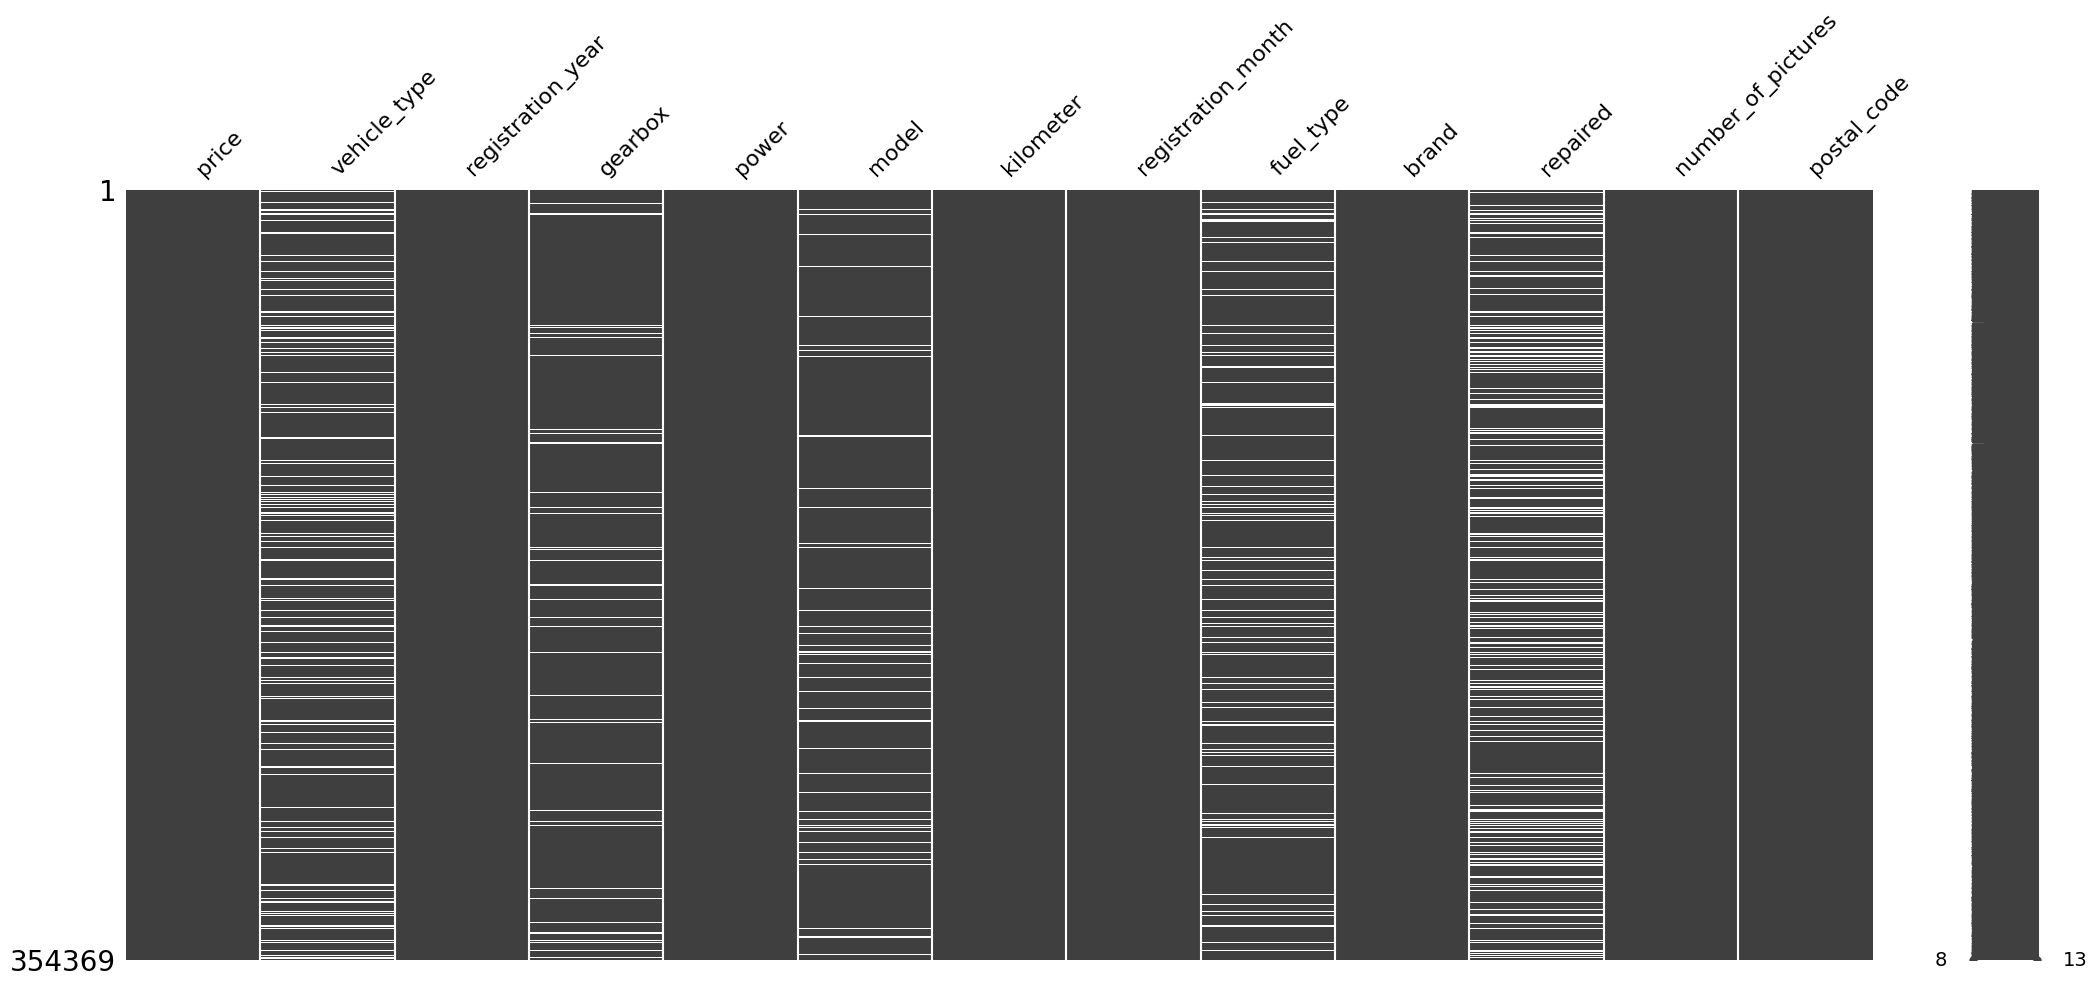

In [15]:
msno.matrix(df);

Характер распределения пропусков - неоднородный. Посмотрим существует ли среди пропусков корреляция.

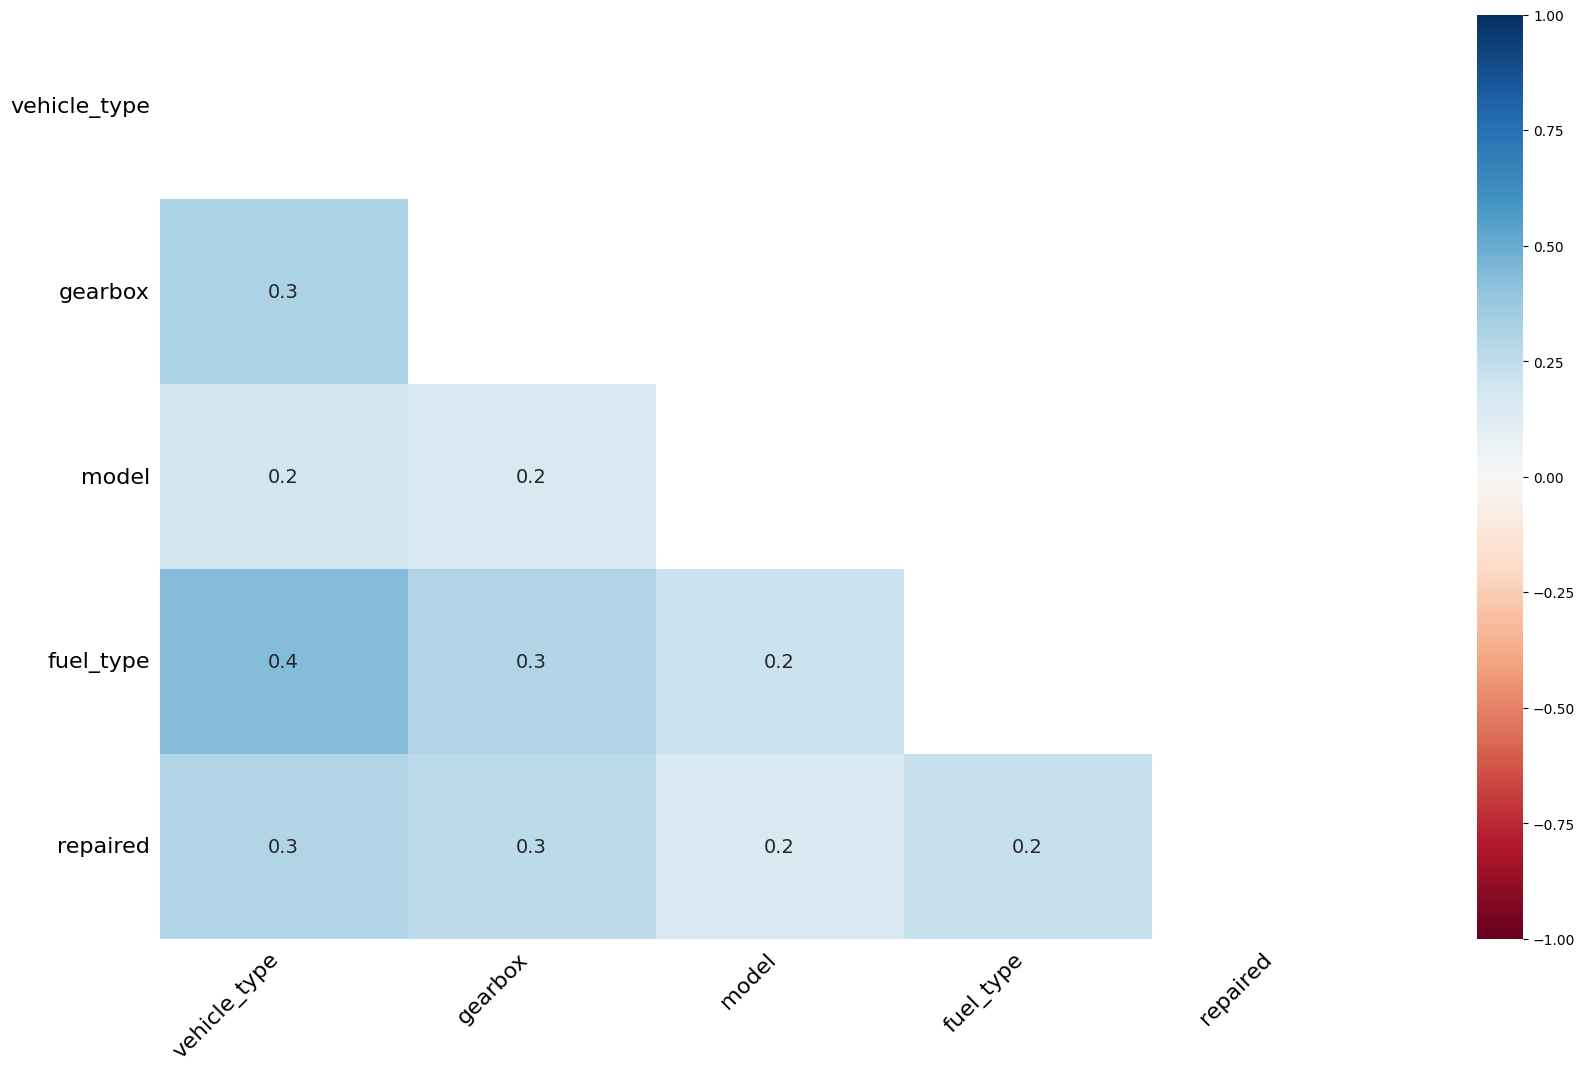

In [16]:
msno.heatmap(df);

Пропуски между собой коррелируют слабо.

Приводим тип топлива к единому значению.

In [17]:
df.fuel_type.replace('gasoline', 'petrol', inplace=True)

In [18]:
nan_cols = df.columns[df.isnull().any()]
print(nan_cols)

Index(['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired'], dtype='object')


Для визуализации количественных признаков применим функцию.

In [19]:
def hist_box(df, bins='auto'):
    '''
    Функция принимает датафрейм где по каждому числовому признаку рисует гистограмму и ящик с усами.
    А по каждому категеориальному - bar и pie.
    '''
    display(df.describe(include='all'))
    num_cols = df.select_dtypes(include='number').columns.tolist()
    for num_col in num_cols:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
        f = sns.histplot(x=num_col, data=df, bins=bins, kde=True, ax=axes[0])
        f = sns.boxplot(x=num_col, data=df, ax=axes[1])
        f = fig.suptitle(str.upper(num_col))
        plt.show()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,number_of_pictures,postal_code
count,354369.00,316879,354369.00,334536,354369.00,334664,354369.00,354369.00,321474,354369,283215,354369.00,354369.00
unique,NaN,8,NaN,2,NaN,250,NaN,NaN,6,40,2,NaN,NaN
top,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,NaN,NaN
freq,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,315072,77013,247161,NaN,NaN
mean,4416.66,NaN,2004.23,NaN,110.09,NaN,128211.17,5.71,NaN,NaN,NaN,0.00,50508.69
std,4514.16,NaN,90.23,NaN,189.85,NaN,37905.34,3.73,NaN,NaN,NaN,0.00,25783.10
min,0.00,NaN,1000.00,NaN,0.00,NaN,5000.00,0.00,NaN,NaN,NaN,0.00,1067.00
25%,1050.00,NaN,1999.00,NaN,69.00,NaN,125000.00,3.00,NaN,NaN,NaN,0.00,30165.00
50%,2700.00,NaN,2003.00,NaN,105.00,NaN,150000.00,6.00,NaN,NaN,NaN,0.00,49413.00
75%,6400.00,NaN,2008.00,NaN,143.00,NaN,150000.00,9.00,NaN,NaN,NaN,0.00,71083.00


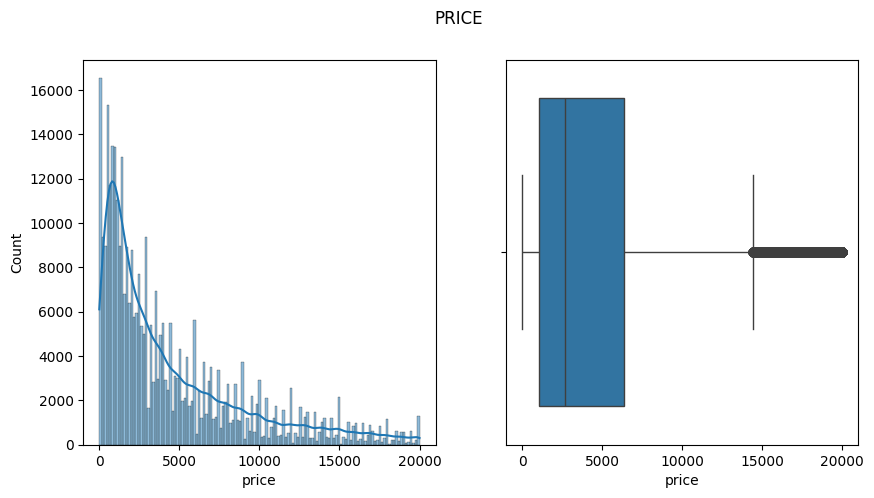

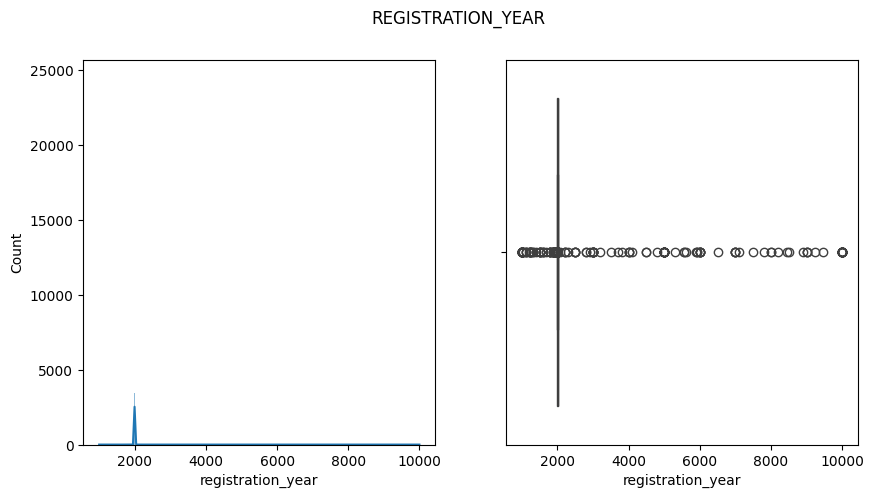

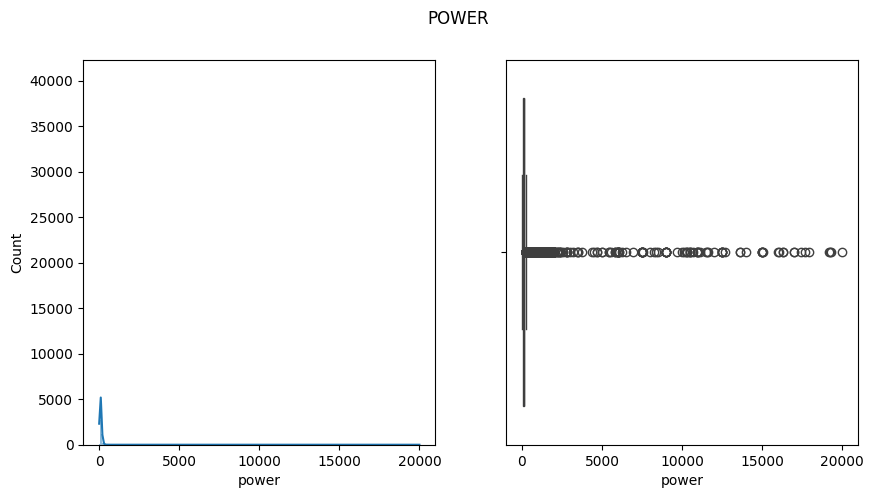

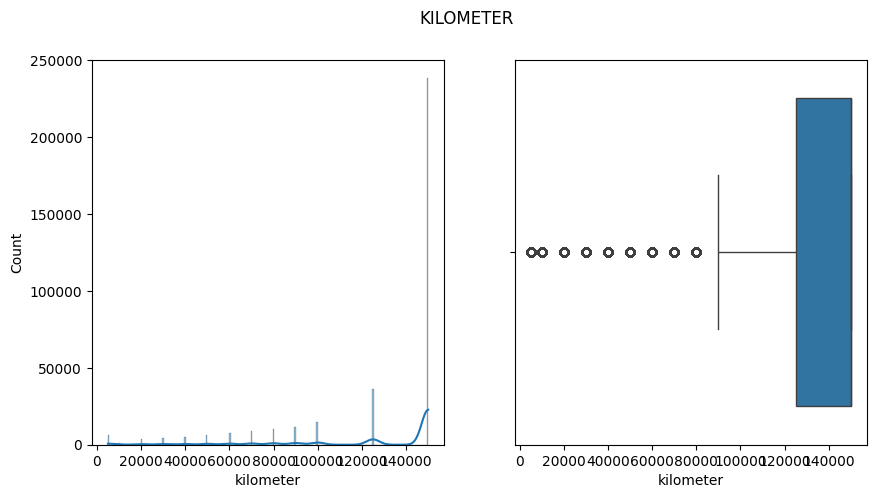

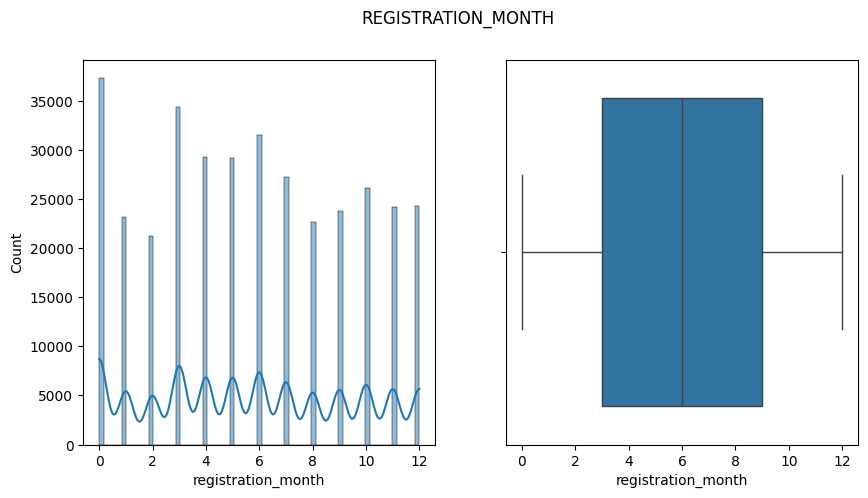

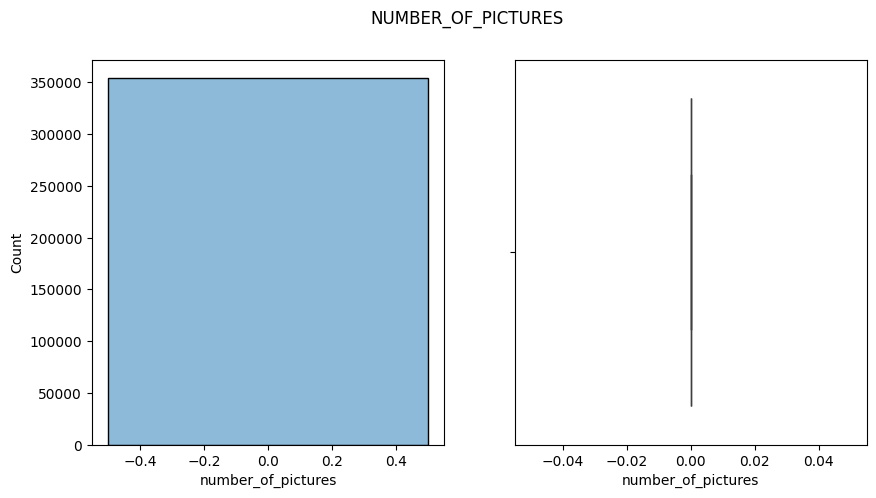

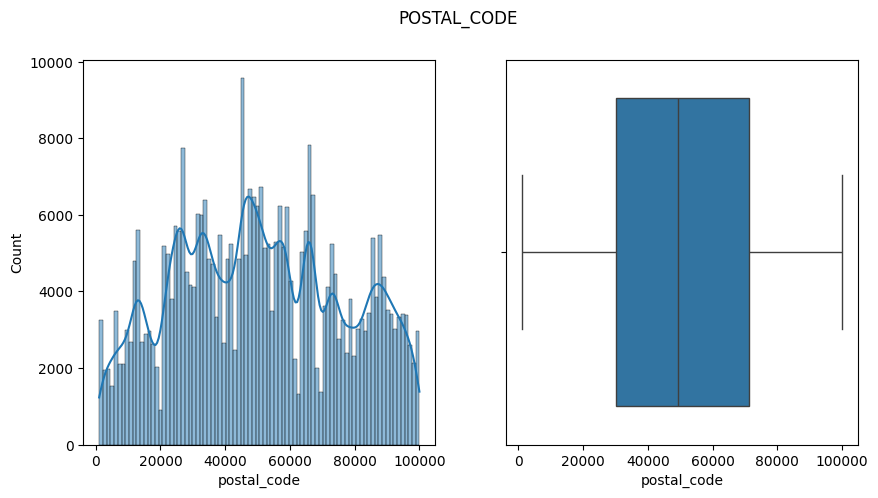

In [20]:
hist_box(df)

РЕдактируем данные по столбцу Год регистрации. Выведем уникальгные значения.

In [21]:
years = df.registration_year.unique().tolist()
years.sort()
print(years)

[1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500, 1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000, 3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555, 5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200, 8455, 8500, 8888, 9000, 9229, 9450, 9996, 9999]


Посчитаем количество записей с некорректным годом - где значение меньше 1960 года и больше 2016 (поскольку дата выгрузки базы - 2016 год). 

In [22]:
df[(df['registration_year'] < 1960) | (df['registration_year'] > 2016)].registration_year.count()

14952

Таких записей немного - 14952. Удаляем. Проверяем.

In [23]:
df.shape

(354369, 13)

In [24]:
# df = df[(df.registration_year >= 1960) | (df.registration_year <= 2020)]
df = df[(df.registration_year <= 2016)]
df = df[(df.registration_year >= 1960)]

In [25]:
df.shape

(339417, 13)

Мощность двигатея неправдоподобная. Максимальная сейчас у автомобилей в мире за редким исключением  не больше 1000 л.с. Ограничим этим значением.

In [26]:
df = df[(df.power <= 1000)]

In [27]:
df.shape[0]

339141

Смотрим на признак Мощность двигателя.

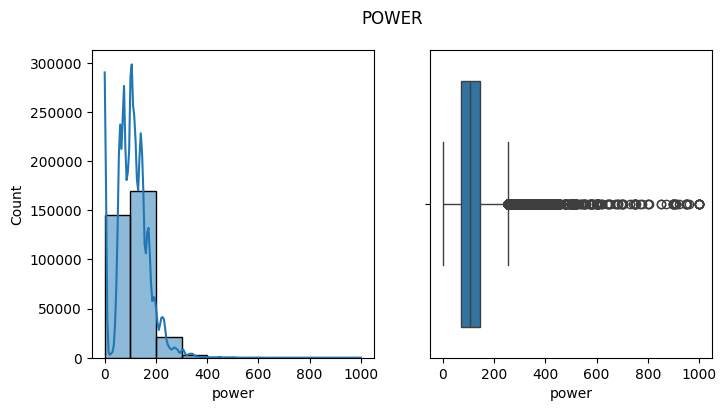

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
f = sns.histplot(x='power', data=df, bins=10, kde=True, ax=axes[0])
f = sns.boxplot(x='power', data=df, ax=axes[1])
f = fig.suptitle(str.upper('power'))
plt.show()

Удалим выбросы при помощи функции, которая убирает все значения, которые выходят за границу размера межквартильного  размаха, умноенного на 1,5 с каждой из сторон диапазона значений (по нижней и верхней границам).

In [29]:
def outliers_delete_iqr(df, col):
    '''
    Удаление значений за пределами 1,5 * IQR.
    Аргументы: датафрейм и колонка данных.
    '''
    q_low = df[col].quantile(0.25)
    q_hi  = df[col].quantile(0.75)
    iqr = q_hi - q_low
    df_filtered = df[(df[col] < q_hi+1.5*iqr) & (df[col] > q_low-1.5*iqr)]
    return df_filtered

А для наглядности ее расширенной версией.

In [30]:
def outliers_delete_iqr_hist_box(df, col):
    '''
    Удаление значений за пределами 1,5 * IQR.
    Аргументы: датафрейм и колонка данных.
    Строит гистограмму и боксплот.
    Аргументы:
    df - фрейм данных
    col - название колонки данных.
    '''
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
    f = sns.histplot(x=col, data=df, bins='auto', kde=True, ax=axes[0])
    f = sns.boxplot(x=col, data=df, ax=axes[1])
    f = fig.suptitle(str.upper(col) + ' до удаления выбросов')
    plt.show()
    n1 = df.shape[0]
    print('Количество записей до:', df.shape[0])
    q_low = df[col].quantile(0.25)
    q_hi  = df[col].quantile(0.75)
    iqr = q_hi - q_low
    df = df[(df[col] < q_hi+1.5*iqr) & (df[col] > q_low-1.5*iqr)]
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
    f = sns.histplot(x=col, data=df, bins='auto', kde=True, ax=axes[0])
    f = sns.boxplot(x=col, data=df, ax=axes[1])
    f = fig.suptitle(str.upper(col) + ' после удаления выбросов')
    plt.show()
    print('Удалено строк:', n1-df.shape[0])
    print('Количество записей после:', df.shape[0])
    return df

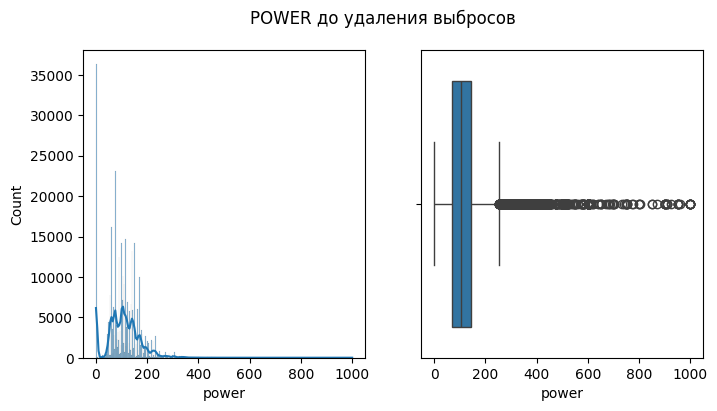

Количество записей до: 339141


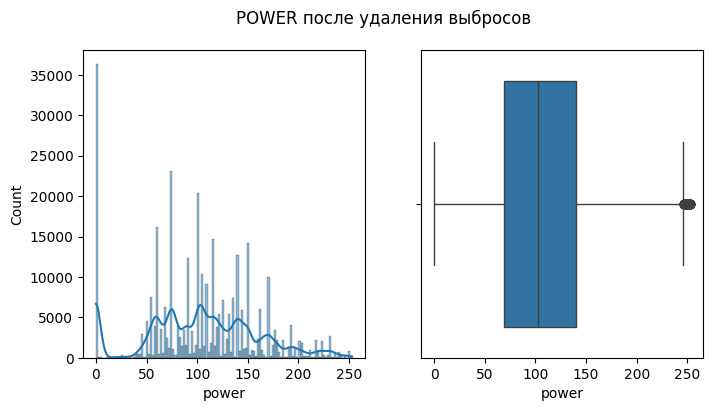

Удалено строк: 6855
Количество записей после: 332286


In [31]:
df = outliers_delete_iqr_hist_box(df, 'power')

Ищем строки с нулевой ценой.

In [32]:
df[df.price==0].price.count()

9762

Очевидно, что такие записи не помогут в построении прогноза стоимостси автомобиля. Посмотрим на распределение данных сейчас.

In [33]:
df.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,332286.00,332286.00,332286.00,332286.00,332286.00,332286.00,332286.00
mean,4338.34,2002.54,103.55,128063.08,5.75,0.00,50573.17
std,4423.77,6.76,56.43,37886.45,3.71,0.00,25798.68
min,0.00,1960.00,0.00,5000.00,0.00,0.00,1067.00
25%,1000.00,1999.00,69.00,125000.00,3.00,0.00,30167.00
50%,2700.00,2003.00,103.00,150000.00,6.00,0.00,49479.00
75%,6200.00,2007.00,140.00,150000.00,9.00,0.00,71126.00
max,20000.00,2016.00,253.00,150000.00,12.00,0.00,99998.00


Цена, мощность, месяц регистрации содержат нули. Очевидно, что это говорит об отсутствии информации. В данном случае нет смысла в том чтобы ставить на место пропущенных значений заглушки.  Поэтому удаляем. И проверяем.

In [34]:
df = df[df.power != 0]
df = df[df.price != 0]
df = df[df.registration_month != 0]

In [35]:
df.shape

(272096, 13)

Удалим столбец number_of_pictures - там данных нет совсем.

In [36]:
df.drop('number_of_pictures', axis=1, inplace=True)

Ищем полные дубликаты записей. И удаляем их. Оставляем первые записи, все последующие одинаковые удаляем.

In [37]:
df_duplicated = df[df.duplicated()]
df_duplicated.shape

(17689, 12)

In [38]:
df = df.drop_duplicates(keep='first')
df.shape

(254407, 12)

Удаляем выбросы в колонках цены и года регистрации.

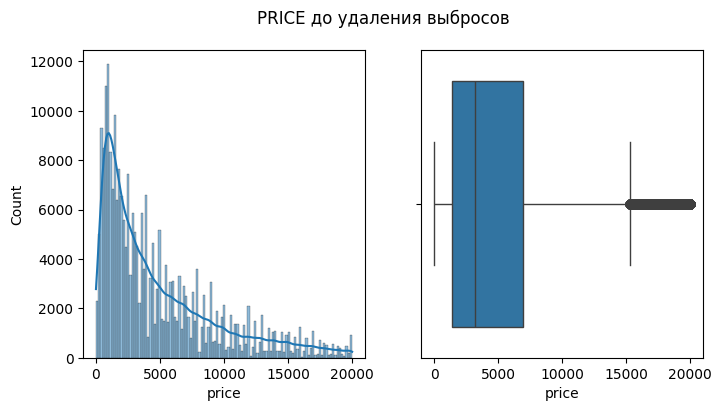

Количество записей до: 254407


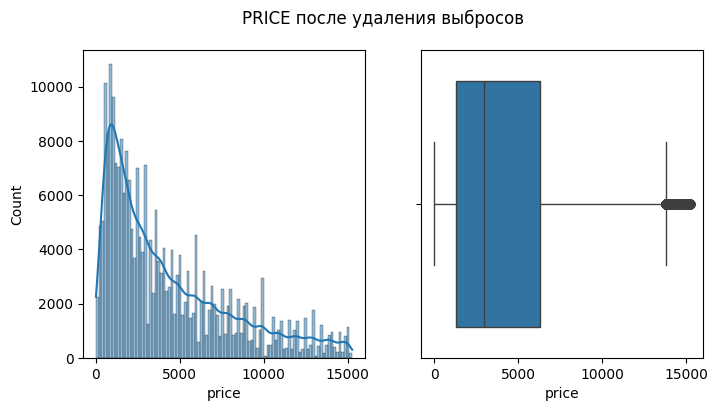

Удалено строк: 11272
Количество записей после: 243135


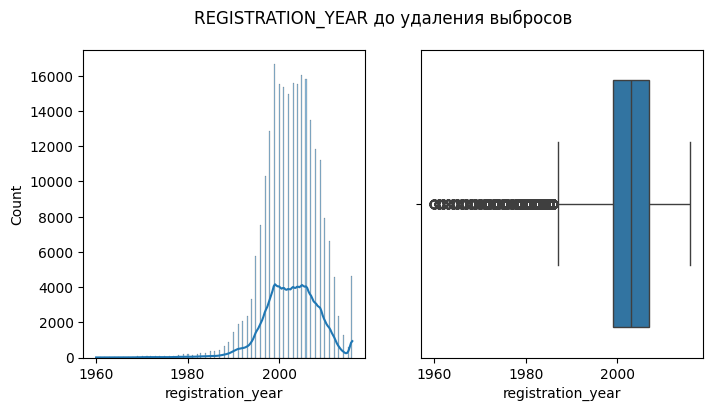

Количество записей до: 243135


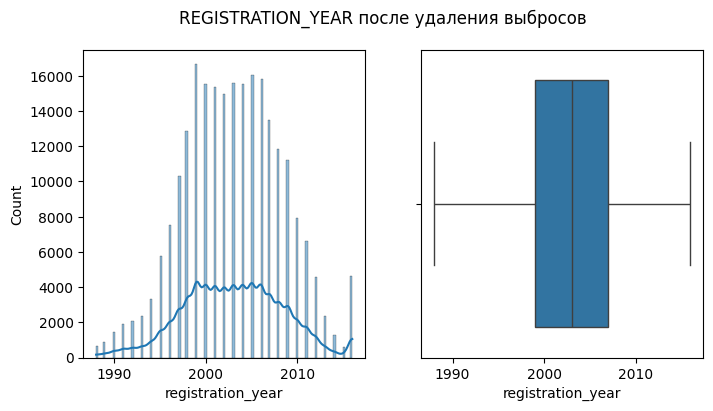

Удалено строк: 3818
Количество записей после: 239317


In [39]:
num_cols = ['price', 'registration_year']
for col in num_cols:
    df = outliers_delete_iqr_hist_box(df, col)

Построим матрицу корреляций Phik

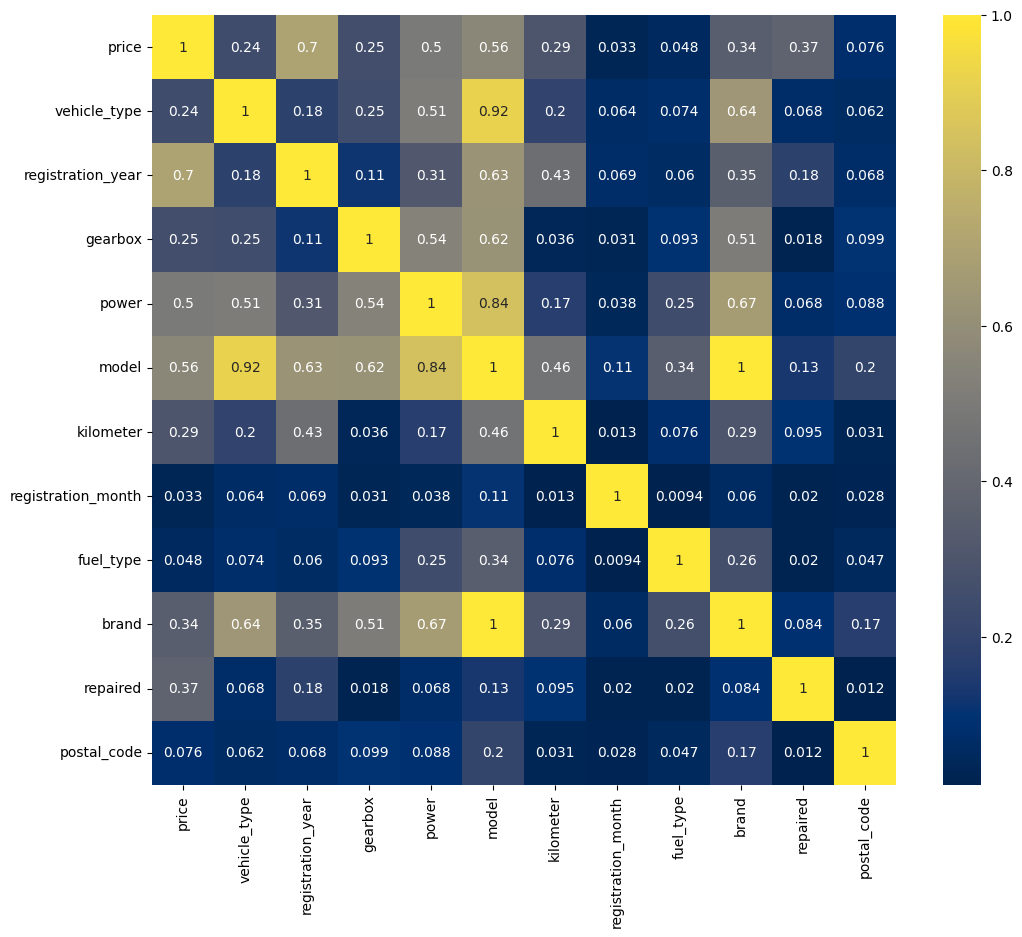

In [40]:
num_cols = df.select_dtypes(include='number').columns.tolist()
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(df.phik_matrix(interval_cols=num_cols,) , annot=True, cmap='cividis');
plt.show()

Выводы. 100% колинеарность между брендом и моделью.  Модель и тип кузова тоже сильно коррелируют. Посмотрим как эти признаки поведут себя на этапе прогноза. Модели могут учитывать связь между таргетом (ценой) в комбинации с какими-то признаками. Признаки по отдельности могут быть не информативны, а в паре вполне могут иметь значение для моделей. 

Построим корреляцию Спирмена

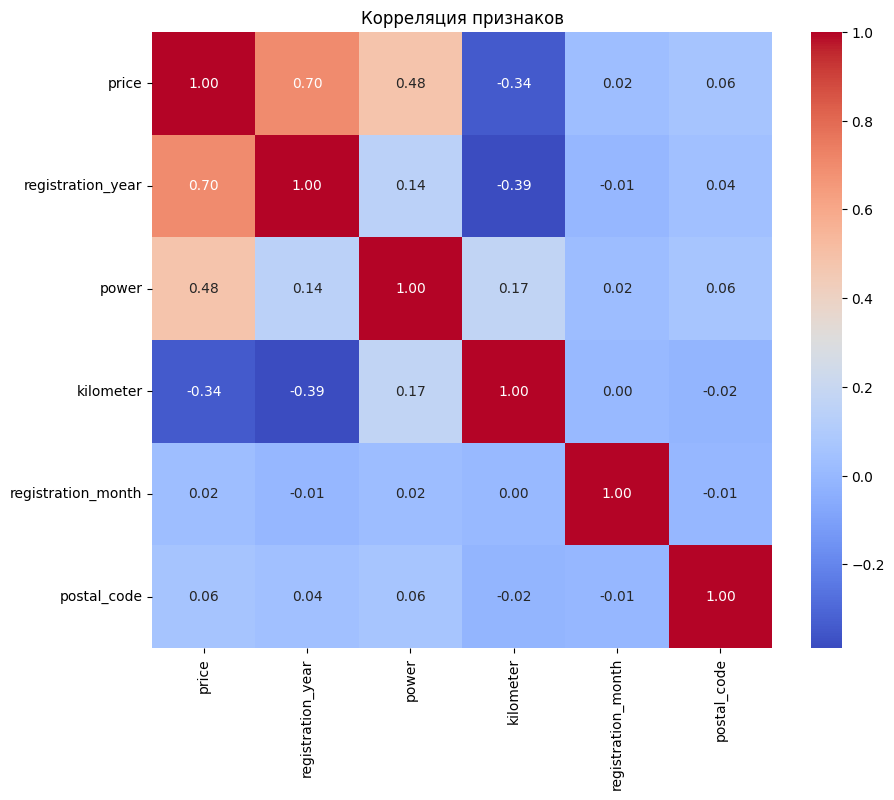

In [41]:
num_cols = df.select_dtypes(include='number').columns.tolist()
plt.figure(figsize=(10,8))

fig = sns.heatmap(df[[*num_cols]].corr(method='spearman'), annot=True, fmt='.2f', cmap='coolwarm')
fig.set_title('Корреляция признаков')
plt.show()

Почтовый код и месяц регистрации - корреляция отсутствует. Убираем.

In [42]:
df.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'repaired', 'postal_code'],
      dtype='object')

In [43]:
df.drop(['registration_month', 'postal_code'], axis=1, inplace=True)

Данные подготовлены. Для оптимизации памяти приведем числовые признаки датафрейма к более компактным форматам данных.

In [44]:
# Оптимизация числовых типов данных
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
    '''
    Function optimizes memory usage in dataframe
    df: pd.DataFrame - data table
    print_size: bool - display of optimization results
    return pd.DataFrame - amount of optimized memory
    '''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию
    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024**2    
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)  
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)    
    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024**2
    if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                         .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return df

In [45]:
df = optimize_memory_usage(df)

Размер использования памяти: до 20.08 Mb - после 15.06 Mb (25.0%)


## Подготовка выборок

Делим датафрем на свойства и таргет - X и y.

In [46]:
X = df.drop('price', axis=1)
y = df['price']

Деим данные на тренировочную и тестовую выборки в соотношении 75%/25% (по умолчанию).

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE
)

In [48]:
num_cols = X_train.select_dtypes(exclude=['object']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
print('Числовые признаки', num_cols)
print('Категориальные признаки', cat_cols)
df.shape

Числовые признаки ['registration_year', 'power', 'kilometer']
Категориальные признаки ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']


(239317, 10)

## Построение моделей

### Линейная регрессия

Готовим данные для линейных моделей. Заполняем пропуски в числовых признаках средним. А в категориальных - самым частым значением. Числовые данные скалируем (StandardScaler), категориальные - кодируем (OneHotEncoder).

In [49]:
pipe_num = Pipeline([
    ('imp_num', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scale'), StandardScaler(),
#     ('imp_num_2', SimpleImputer(missing_values=np.nan, strategy='mean')),
])

pipe_cat = Pipeline([
    ('imp_cat', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)),
])

linear_prep = ColumnTransformer([
    ('cat', pipe_cat, cat_cols),
    ('num', pipe_num, num_cols),

], remainder='passthrough')

lin_pipe = Pipeline([
    ('prep', linear_prep),
#     ('model', LinearRegression())
    ('model', Ridge())
])

In [50]:
%%time
start_time = time.time()

param = {
    'model__alpha': range(1, 100, 4),
    'prep__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}


rand_search_linear = RandomizedSearchCV(
    lin_pipe, 
    param, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    n_iter=10
)

rand_search_linear.fit(X_train, y_train)
print('Лучшие параметры:', rand_search_linear.best_params_)
print ('RMSE на кроссвалидации:', -(rand_search_linear.best_score_))


linear_model_time = time.time() - start_time
print('Время расчета модели:', linear_model_time)

Лучшие параметры: {'prep__num': StandardScaler(), 'model__alpha': 1}
RMSE на кроссвалидации: 2011.0033865825667
Время расчета модели: 71.58530497550964
CPU times: total: 12.1 s
Wall time: 1min 11s


Рассчитаем несколько моделей с подбором гиперпараметров. найдем лучшую среди них. Готовим даные для перебора в пайплайне.

### Градиентный бустинг

Пробуем предсказаать результат градиентным бустингом.

#### Light GBM

Для корректной работы LightGBM предварительно приводим категориальные признаки к типу category (.astype('category')), чтобы модель обрабатывала их как категориальные.

In [51]:
%%time
start_time = time.time()

X_train_cat = X_train.copy()
X_train_cat[cat_cols] = X_train_cat[cat_cols].astype('category')

lgbm_model = LGBMRegressor(categorical_feature=cat_cols)

lgbm_param = {
    'boosting_type': ['gbdt', 'dart'],
    'max_depth': [-1, 5],
}

grid_search_lgbm = GridSearchCV(
    estimator=lgbm_model,
    param_grid=lgbm_param,
    cv=2,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search_lgbm.fit(X_train_cat, y_train)
print('Лучшие параметры:', grid_search_lgbm.best_params_)
print('Метрика лучшей модели:', grid_search_lgbm.best_score_)

lgbm_model_time = round(time.time() - start_time)
print('Время расчета модели:', lgbm_model_time)

[LightGBM] [Warning] categorical_feature is set=vehicle_type,gearbox,model,fuel_type,brand,repaired, categorical_column=0,2,4,6,7,8 will be ignored. Current value: categorical_feature=vehicle_type,gearbox,model,fuel_type,brand,repaired
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 590
[LightGBM] [Info] Number of data points in the train set: 179487, number of used features: 9
[LightGBM] [Info] Start training from score 4220.694730
Лучшие параметры: {'boosting_type': 'gbdt', 'max_depth': -1}
Метрика лучшей модели: -1339.961194251852
Время расчета модели: 12
CPU times: total: 4 s
Wall time: 12.4 s


#### CatBoost

Для модели CatBoost используем аргумент cat_features для указания, какие признаки являются категориальными. 

In [52]:
%%time
start_time = time.time()

X_train[cat_cols] = X_train[cat_cols].astype(str)
catboost_model = CatBoostRegressor(loss_function='RMSE', cat_features=cat_cols, verbose=False)

catboost_param = [{
    'iterations': [100, 300],
    'depth': [4, 6]
}]

catboost_grid = GridSearchCV(
    estimator=catboost_model,
    param_grid=catboost_param,
    cv=2,
    scoring='neg_root_mean_squared_error'
)

catboost_grid.fit(X_train, y_train)
# result_catboost = pd.DataFrame(catboost_grid.cv_results_)

print('Лучшие параметры:', catboost_grid.best_params_)
print('Метрика лучшей модели:', catboost_grid.best_score_)

cb_model_time = time.time() - start_time
print('Время расчета модели:', cb_model_time)

Лучшие параметры: {'depth': 6, 'iterations': 300}
Метрика лучшей модели: -1346.538378268317
Время расчета модели: 169.62433290481567
CPU times: total: 13min 12s
Wall time: 2min 49s


## Анализ моделей

Сравниваем показатели времени обучения и качества.

In [53]:
print('Время обучения линейной модели:', round(linear_model_time),  ', метрика модели:', rand_search_linear.best_score_)
print('Время обучения ligtGBM модели:', round(lgbm_model_time), ', метрика модели:', grid_search_lgbm.best_score_)
print('Время обучения CatBoost модели:', round(cb_model_time), ', метрика модели:', catboost_grid.best_score_)

Время обучения линейной модели: 72 , метрика модели: -2011.0033865825667
Время обучения ligtGBM модели: 12 , метрика модели: -1339.961194251852
Время обучения CatBoost модели: 170 , метрика модели: -1346.538378268317


Лучше отработала модель ligtGBM.
Считаем ее предсказания на тестовой выборке.

In [54]:
X_test_cat = X_test.copy()
X_test_cat[cat_cols] = X_test_cat[cat_cols].astype('category')

grid_search_lgbm.predict(X_test_cat)
print('Значение метрики на тестовой выборке: ', root_mean_squared_error(y_test, grid_search_lgbm.predict(X_test_cat)).round(2))
print('Параметры модели: ', grid_search_lgbm.best_params_)

Значение метрики на тестовой выборке:  1323.77
Параметры модели:  {'boosting_type': 'gbdt', 'max_depth': -1}


## Вывод
В процессе исследования была проведена предобработка и выбраны признаки по которым делается регрессия. Были использованы линейная модель, LightGBM, CatBoost. Лучшее время обучения и показатель точности показала модель LightGBM с параметрами {'boosting_type': 'gbdt', 'max_depth': -1} - 128 сек, RMSE - 1324.
Средняя ошибка модели в расчете цены - 1324 евро, это укладывается в показатель предсказания меньше 2400.